#  Lucas Kanade Feature Tracking

In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

## Overview

In the problem, we implement a corner detector and feature tracker that track features from the image sequence hotel.

<img src="https://drive.google.com/uc?id=1sBtKpU2mYEPZ9c2Cvw-DBuLBPK2gYwC-" width="700"/>

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
# Load Initial Key Points
data = loadmat('/content/initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']

Downloading...
From: https://drive.google.com/uc?id=1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
To: /content/part1_images.zip
100% 5.10M/5.10M [00:00<00:00, 240MB/s]
Archive:  /content/part1_images.zip
   creating: /content/part1_images/
  inflating: /content/part1_images/hotel.seq41.png  
  inflating: /content/part1_images/hotel.seq40.png  
  inflating: /content/part1_images/hotel.seq42.png  
  inflating: /content/part1_images/hotel.seq43.png  
  inflating: /content/part1_images/hotel.seq47.png  
  inflating: /content/part1_images/hotel.seq46.png  
  inflating: /content/part1_images/hotel.seq50.png  
  inflating: /content/part1_images/hotel.seq44.png  
  inflating: /content/part1_images/hotel.seq8.png  
  inflating: /content/part1_images/hotel.seq9.png  
  inflating: /content/part1_images/hotel.seq45.png  
  inflating: /content/part1_images/hotel.seq36.png  
  inflating: /content/part1_images/hotel.seq22.png  
  inflating: /content/part1_images/hotel.seq23.png  
  inflating: /content/part1_imag

## Helper Functions

In [ ]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png',cv2.IMREAD_GRAYSCALE))
  return np.array(arr_images, dtype=np.float32)

# read all 51 sequences of images
folder = '/content/part1_images/'
im = readImages(folder, 51)

## 1.1 Keypoint Selection using Harris Corner Detection

For the first frame, we use the second moment matrix to locate strong corners to use as keypoints.
These points will be tracked throughout the sequence in the second part of the problem. Choose a proper threshold so that edges and noisy patches are ignored. We perform local non-maxima suppression over a 5x5 window centered at each point.
This should give several hundred good points to track.

### Code

In [ ]:
def normalize_array(arr, max, min):
  max_val = np.max(arr)
  min_val = np.min(arr)
  arr = ((arr - min_val)/(max_val-min_val))*max + min
  return arr

def plotKeyPoints(img, keypoints):
  plt.rcParams["figure.figsize"] = [10, 10]
  plt.rcParams["figure.autolayout"] = True
  fig, ax = plt.subplots()
  im = ax.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]], cmap='gray')
  # ax.plot(x, x, ls='dotted', linewidth=2, color='red')
  ax.scatter(keypoints[:,1], img.shape[0] - keypoints[:,0], color = 'g', s = 20)
  plt.show()

def createGaussianKernel(ws):
  size = ws #window size
  sigma = (size - 1)/4
  ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
  gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
  weights = np.outer(gauss, gauss)
  weights = weights/np.sum(weights)
  return weights

def getKeypoints(img, tau):
  '''
  Detecting keypoints using Harris corner criterion
  img: input image
  tau: threshold 
  
  output: (N,2) array of [x,y] keypoints
  '''
  # YOUR CODE HERE
  size = 7 #window size
  W_h = int(size/2)
  thresh = tau

  # Creating a gaussian kernel to weigh the window elements according to their distance
  weights = createGaussianKernel(size)
  weights1 = createGaussianKernel(5)

  # Smoothening the image using a Gaussian filter
  # img =  cv2.filter2D(img, -1, weights)

  # Finding derivatives at each point in the image
  kx = np.array([[-1,0,1]])
  ky = np.array([[-1],[0],[1]])
  img = cv2.filter2D(img, -1, weights1)
  dx = cv2.filter2D(img, -1, kx)
  dy = cv2.filter2D(img, -1, ky)

  # Initializing empty arrays
  sig_Ix_2 = np.zeros(img.shape)
  sig_Iy_2 = np.zeros(img.shape)
  sig_Ix_Iy = np.zeros(img.shape)
  scores = np.zeros(img.shape)

  # Populating the scores array with Harris operator scores
  for i in range(W_h, img.shape[0] - W_h, 1):
    for j in range(W_h, img.shape[1] - W_h, 1):

      sig_Ix_2[i,j] = np.sum(np.multiply(weights , (dx[i-W_h:i+W_h+1, j-W_h:j+W_h+1])**2))
      sig_Iy_2[i,j] = np.sum(np.multiply(weights , (dy[i-W_h:i+W_h+1, j-W_h:j+W_h+1])**2))
      sig_Ix_Iy[i,j] = np.sum(np.multiply(weights , np.multiply(dx[i-W_h:i+W_h+1, j-W_h:j+W_h+1], dy[i-W_h:i+W_h+1, j-W_h:j+W_h+1])))

      H = np.array([ [sig_Ix_2[i,j], sig_Ix_Iy[i,j]], [sig_Ix_Iy[i,j], sig_Iy_2[i,j]] ]) #Second moment matrix
      scores[i,j] = (np.linalg.det(H))/(np.trace(H)) #Harris operator scores
    
  scores = normalize_array(scores, 1, 0)

  # Thresholding
  scores[scores < thresh] = 0

  # Non-Max Supression
  indices = np.argwhere(scores>0)

  for k in range(indices.shape[0]):
    row = indices[k,0]
    column = indices[k,1]
    temp = scores[row - 2: row+3 , column - 2 : column + 3]
    temp[temp!=np.max(temp)] = 0
    scores[row - 2: row+3 , column - 2 : column + 3] = temp

  keypoints = np.argwhere(scores>0)

  return keypoints

### Write-up

Implementation of getKeypoints():
- The x and y derivatives were computed for every pixel of the image.
- The second moment matrix 'H' was constructed for every 7x7 window in the image. Harris score was calculated for every pixel by determinant(H)/trace(H)
- Thresholding was done for every pixel in the image by putting the pixel values to 0 for every pixel with its Harris corner score below the threshold level.
- Non-maxima supression was performed by constructing a 5x5 window across every pixel that gave a response after thresholding. In these 5x5 windows all pixel values except the pixel giving the maximum Harris score were put to zero.
- The pixels which were non-zeros were the detected corners.

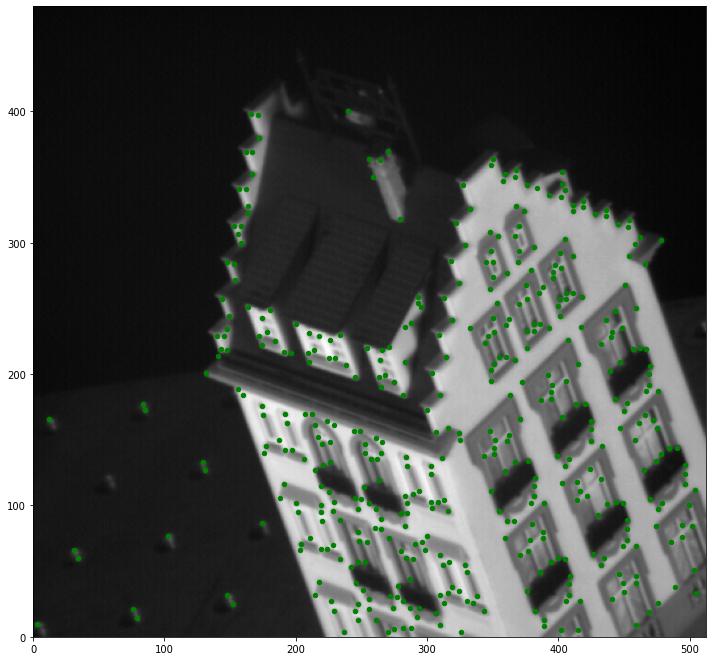

In [ ]:
# compute keypoints in the first sequence
tau = 0.06
key_pts = getKeypoints(im[0], tau)

# add plots for the write-up
# YOUR CODE HERE
plotKeyPoints(im[0], key_pts)

## 1.2 Feature Tracking

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.1 (or the given keypoints in the *Data* section) throughout the hotel sequence. 

<img src="https://drive.google.com/uc?id=1dU4p4YcnXoQFnrNvleEty_4tDECkVW9Q" width="500"/>

Some keypoints will move out of the image frame over the course of the sequence. Discard any track if the predicted translation falls outside the image frame.

*  From the 1st frame to the 2nd frame, use the detected keypoints at the first frame as initialization points. From the 2nd to 3rd frame, use the tracked positions at the 2nd frame as initialization. Note that the tracked keypoints in general are not at integer positions.

*  For each point, use a window size of 15 x 15.

Add codes to **plot** your tracked points overlayed in the **first sequence** and the **last sequence**. They should look similar to the second picture shown in the Overview section. 



### Code

In [ ]:
def plotKeyPoints_LK(img, track_x, track_y, random_sampling=True):
  plt.rcParams["figure.figsize"] = [10, 10]
  plt.rcParams["figure.autolayout"] = True
  fig, ax = plt.subplots()
  im = ax.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]], cmap='gray')

  tr_x = track_x.copy()
  tr_y = track_y.copy()

  if random_sampling:
    random = np.random.randint(low=0, high=track_x.shape[0], size=20)
    tr_x = track_x[random,:]
    tr_y = track_y[random,:]

  x = np.transpose(tr_x).flatten()
  y = np.transpose(tr_y).flatten()

  x_pts = []
  y_pts = []

  for i in range(x.shape[0]):
    if 0 <= x[i] <= img.shape[1] - 1 and 0 <= y[i] <= img.shape[0] - 1:
      x_pts.append(x[i])
      y_pts.append(y[i])

  ax.scatter(np.array(x_pts), img.shape[0] - np.array(y_pts), color = 'r', s = 10)
  pass

def plotOutliers(img, track_x, track_y, outliers):
  plt.rcParams["figure.figsize"] = [10, 10]
  plt.rcParams["figure.autolayout"] = True
  fig, ax = plt.subplots()
  im = ax.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]], cmap='gray')

  x_pts = []
  y_pts = []

  for i in outliers:
    x = track_x[i,:]
    y = track_y[i,:]
    for j in range(x.shape[0]):
      if 0 <= x[j] <= img.shape[1] - 1 and 0 <= y[j] <= img.shape[0] - 1:
        x_pts.append(x[j])
        y_pts.append(y[j])

  ax.scatter(np.array(x_pts), img.shape[0] - np.array(y_pts), color = 'r', s = 10)
  pass

def display12(img, track_x, track_y):
  plt.rcParams["figure.figsize"] = [10, 10]
  plt.rcParams["figure.autolayout"] = True
  fig, ax = plt.subplots()
  im = ax.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]], cmap='gray')

  ax.scatter(track_x[:,0], img.shape[0] - track_y[:,0], color = 'g', s = 20)
  ax.scatter(track_x[:,1], img.shape[0] - track_y[:,1], color = 'r', s = 20)
  pass

def bilinearSubPixel(img, coord):
  y = coord[0]
  x = coord[1]
  dy = coord[0] - int(coord[0])
  dx = coord[1] - int(coord[1])

  weight_tl = (1.0 - dx) * (1.0 - dy)
  weight_tr = (dx)       * (1.0 - dy)
  weight_bl = (1.0 - dx) * (dy)
  weight_br = (dx)       * (dy)

  interp_value = weight_tl*(img[ int(np.floor(y)), int(np.floor(x)) ]) + weight_tr*(img[ int(np.floor(y)), int(np.ceil(x))]) + weight_bl*(img[ int(np.ceil(y)),int(np.floor(x))]) + weight_br*(img[int(np.ceil(y)),int(np.ceil(x))])
  return interp_value

def getSubPixelWindow(img, ws, center):
  arr = np.zeros((ws,ws))
  for i in range(-int(ws/2),int(ws/2) + 1, 1):
    for j in range(-int(ws/2),int(ws/2) + 1, 1):
      arr[i+int(ws/2), j+int(ws/2)] = bilinearSubPixel(img, (center[0] + i, center[1] + j))
  return arr

#Both the above functions aren't being used.

def trackPoints(pt_x, pt_y, im, ws):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  N = np.prod(pt_x.shape)
  nim = len(im)
  track_x = np.zeros((N, nim))
  track_y = np.zeros((N, nim))
  track_x[:,0] = pt_x
  track_y[:,0] = pt_y
  outliers = set()

  # Creating a gaussian kernel to weigh the window elements according to their distance
  weights = createGaussianKernel(ws)

  for t in range(nim-1):
    track_x[:, t+1], track_y[:, t+1] = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws, weights, outliers)
    print("Frame " + str(t) + " done")

  return track_x, track_y, outliers

def getNextPoints(x, y, im1, im2, ws, weights, outliers):
  '''
  Iterative Lucas-Kanade feature tracking
  x,  y : initialized keypoint position in im2
  ws: patch window size

  output: tracked keypoint positions in im2
  '''
  # YOUR CODE HERE
  k = x
  l = y

  x = np.float64(x)
  y = np.float64(y)

  im1 = cv2.GaussianBlur(im1,(5,5),0)
  kx = np.array([[-1,0,1]])
  ky = np.array([[-1],[0],[1]])
  Ix = cv2.filter2D(im1, -1, kx)
  Iy = cv2.filter2D(im1, -1, ky)

  W_h = int(ws/2)

  output = np.zeros((x.shape[0],2))

  for i in range(x.shape[0]): #Iterating through the points

    if y[i] >= im1.shape[0] - W_h - 1 or y[i] <= 0 or x[i] >= im1.shape[1] - W_h - 1 or x[i] <= 0: #Checking for points moving out of the frame
      output[i,:] = np.array([y[i], x[i]])
      outliers.add(i)
      continue

    #Constructing the second moment matrix
    w_Ix = cv2.getRectSubPix(Ix, (ws,ws), (x[i],y[i]))
    w_Iy = cv2.getRectSubPix(Iy, (ws,ws), (x[i],y[i]))

    sig_Ix_2 = np.sum(np.multiply(weights , (w_Ix)**2))
    sig_Iy_2 = np.sum(np.multiply(weights , (w_Iy)**2))
    sig_Ix_Iy = np.sum(np.multiply(weights , np.multiply(w_Ix, w_Iy)))

    H = np.array([[sig_Ix_2, sig_Ix_Iy], 
                  [sig_Ix_Iy, sig_Iy_2]])

    w_It = cv2.getRectSubPix(im2, (ws,ws), (x[i],y[i])) - cv2.getRectSubPix(im1, (ws,ws), (x[i],y[i]))
    x_t = x[i]
    y_t = y[i]

    flag = 1
    
    #Iterating to optimize for u and v for every point
    for j in range(20): 
      if j != 0:
        x_t = x[i] + u
        y_t = y[i] + v
        if y_t > im2.shape[0]-W_h-1 or x_t > im2.shape[1]-W_h-1:
          output[i,:] = np.array([x_t, y_t])
          flag = 0
          break
        w_It = cv2.getRectSubPix(im2, (ws,ws), (x_t,y_t)) - cv2.getRectSubPix(im1, (ws,ws), (x[i],y[i]))

      b = np.array([ [-1 * np.sum(np.multiply(weights, np.multiply(w_Ix,w_It)))], [-1 * np.sum(np.multiply(weights, np.multiply(w_Iy,w_It)))] ])
      disp = np.dot(np.linalg.inv(H),b)
      u = disp[0][0]
      v = disp[1][0]
    
    x_t = x[i] + u
    y_t = y[i] + v

    if flag == 1:
      output[i,:] = np.array([x_t,y_t])

  return [output[:,0], output[:,1]]

In [ ]:
# track keypoints across the sequences, getNextPoints() is called inside the trackPoints() function
ws = 15
track_x, track_y, outliers = trackPoints(pt_x=key_pts[:,1], pt_y=key_pts[:,0], im=im, ws=ws)

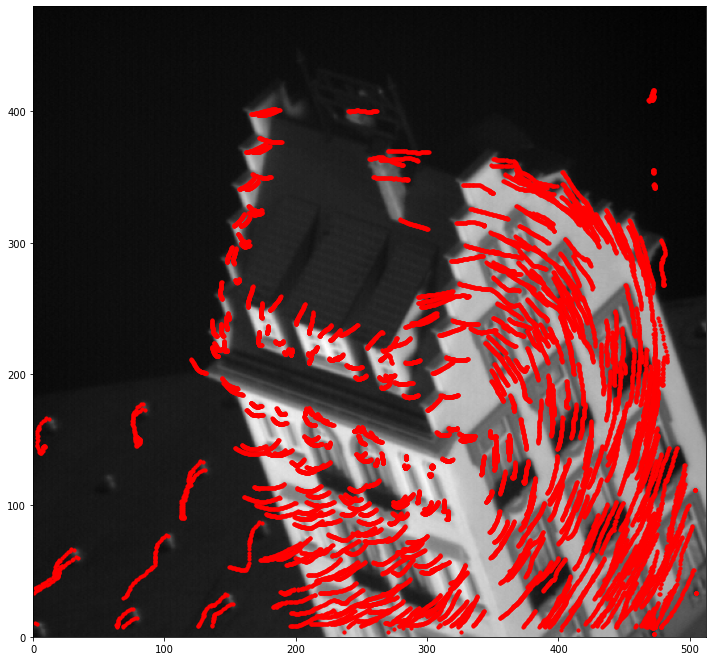

In [ ]:
plotKeyPoints_LK(im[0], track_x, track_y, random_sampling=False)

The implementation of the algorithm wasn't able to capture the motion of the points to the bottom left of the frame. This is probably due to their weak response in corner detection which is the basis for the Lucas Kanade algorithm as well. (Second moment matrix). I tried improving the same by experimenting with smoothening, it wasn't helping.

All the three results have been displayed below:

Keypoints on 1st frame - Green
Keypoints on 2nd frame - Red

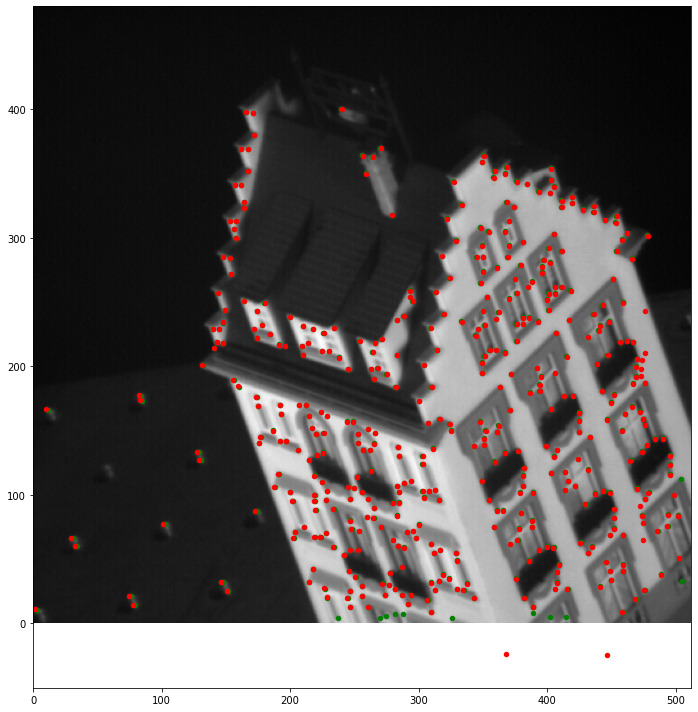

In [ ]:
display12(im[0], track_x, track_y)

Displaying randomly sampled results for 20 points across the frames

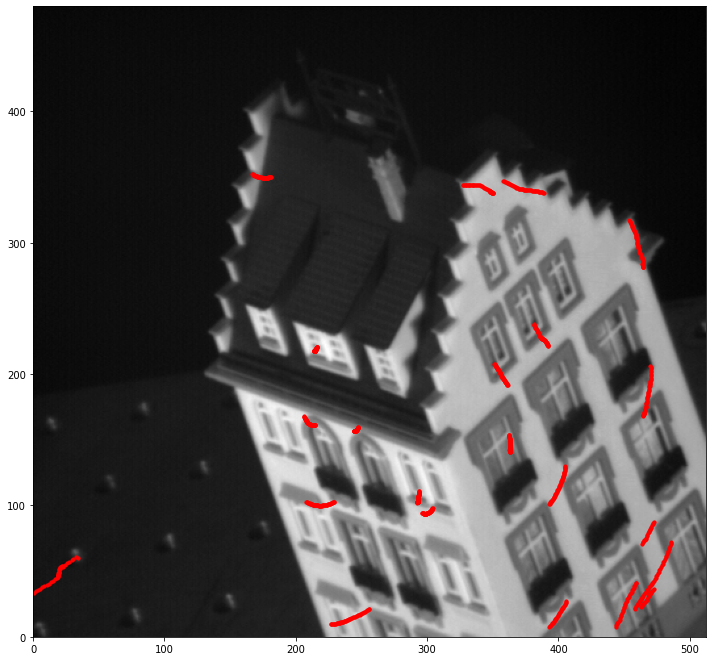

In [ ]:
plotKeyPoints_LK(im[0], track_x, track_y)

Displaying all the points that move out of the frame with time

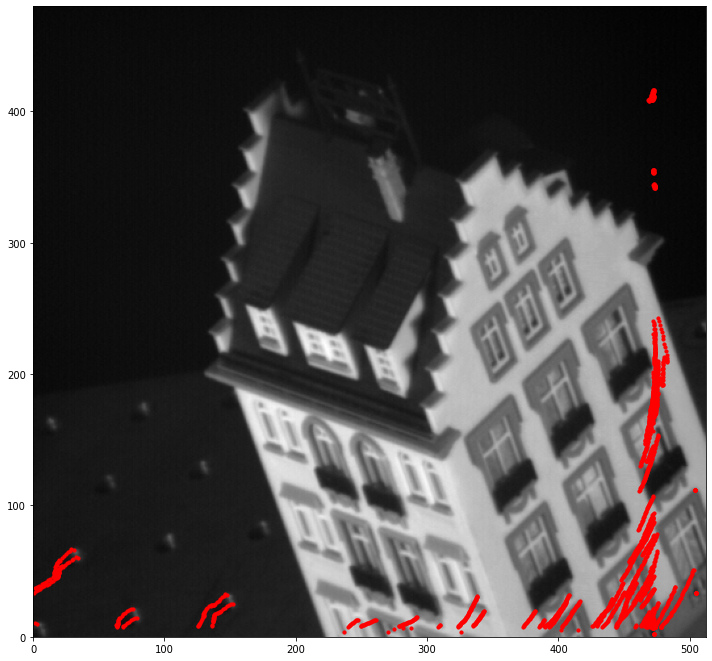

In [ ]:
plotOutliers(im[0], track_x, track_y, outliers)